# QTau Performance Benchmarking and Analysis

This notebook provides comprehensive tools for benchmarking and analyzing QTau performance across different configurations.

## Overview

Performance benchmarking is crucial for:
- Understanding system capabilities
- Identifying bottlenecks
- Optimizing resource allocation
- Comparing different configurations

### Table of Contents
1. [Setup and Data Loading](#setup)
2. [Throughput Analysis](#throughput)
3. [Latency Analysis](#latency)
4. [Scaling Efficiency](#scaling)
5. [Resource Utilization](#resources)
6. [Comparative Analysis](#comparison)

## 1. Setup and Data Loading <a id="setup"></a>

In [1]:
# Import required libraries
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 11

print("Imports successful!")
print(f"Analysis started: {datetime.now()}")

Imports successful!
Analysis started: 2025-12-23 22:12:21.830558


In [2]:
def generate_benchmark_data(n_runs=100, n_configs=4):
    """
    Generate synthetic benchmark data similar to QTau metrics.csv output.
    In production, you would load actual metrics from:
    pd.read_csv(os.path.join(pcs.pcs_working_directory, 'metrics.csv'))
    """
    np.random.seed(42)
    
    configs = [
        {'nodes': 1, 'cores': 64, 'engine': 'dask'},
        {'nodes': 2, 'cores': 128, 'engine': 'dask'},
        {'nodes': 2, 'cores': 128, 'engine': 'ray'},
        {'nodes': 4, 'cores': 256, 'engine': 'ray'},
    ]
    
    data = []
    base_time = datetime.now() - timedelta(hours=2)
    
    for config_id, config in enumerate(configs):
        for run_id in range(n_runs):
            # Simulate performance characteristics
            base_exec_time = 1.0 / (config['cores'] / 64)  # Faster with more cores
            
            # Ray has lower latency than Dask
            engine_factor = 0.8 if config['engine'] == 'ray' else 1.0
            
            submit_time = base_time + timedelta(seconds=run_id * 0.1 + config_id * n_runs * 0.1)
            wait_time = np.random.exponential(0.1 * engine_factor)
            exec_time = np.random.exponential(base_exec_time * engine_factor)
            staging_time = np.random.exponential(0.02)
            
            data.append({
                'task_id': f'task-{config_id}-{run_id}',
                'config_id': config_id,
                'nodes': config['nodes'],
                'cores': config['cores'],
                'engine': config['engine'],
                'qtau_scheduled': f'qtau-{config_id}',
                'submit_time': submit_time,
                'wait_time_secs': wait_time,
                'staging_time_secs': staging_time,
                'execution_secs': exec_time,
                'completion_time': submit_time + timedelta(seconds=wait_time + exec_time),
                'input_staging_data_size_bytes': np.random.randint(1000, 50000),
                'status': 'SUCCESS' if np.random.random() > 0.02 else 'FAILED',
            })
    
    return pd.DataFrame(data)

# Generate benchmark data
metrics_df = generate_benchmark_data(n_runs=200, n_configs=4)
metrics_df['total_time_secs'] = metrics_df['wait_time_secs'] + metrics_df['execution_secs']

print(f"Generated {len(metrics_df)} benchmark records")
metrics_df.head(10)

Generated 800 benchmark records


,task_id,config_id,nodes,cores,engine,qtau_scheduled,submit_time,wait_time_secs,staging_time_secs,execution_secs,completion_time,input_staging_data_size_bytes,status,total_time_secs
0,task-0-0,0,1,64,dask,qtau-0,2025-12-23 20:12:23.678102,0.046927,0.026335,3.010121,2025-12-23 20:12:26.735150,45732,SUCCESS,3.057048
1,task-0-1,0,1,64,dask,qtau-0,2025-12-23 20:12:23.778102,0.059029,0.012296,0.105333,2025-12-23 20:12:23.942464,45131,SUCCESS,0.164362
2,task-0-2,0,1,64,dask,qtau-0,2025-12-23 20:12:23.878102,0.105236,0.025603,0.058065,2025-12-23 20:12:24.041404,3433,SUCCESS,0.163302
3,task-0-3,0,1,64,dask,qtau-0,2025-12-23 20:12:23.978102,0.020261,0.014879,0.362754,2025-12-23 20:12:24.361117,28480,SUCCESS,0.383015
4,task-0-4,0,1,64,dask,qtau-0,2025-12-23 20:12:24.078102,0.094637,0.006910,0.150235,2025-12-23 20:12:24.322974,1189,SUCCESS,0.244872
5,task-0-5,0,1,64,dask,qtau-0,2025-12-23 20:12:24.178102,0.096335,0.081764,0.482015,2025-12-23 20:12:24.756451,12394,SUCCESS,0.578349
6,task-0-6,0,1,64,dask,qtau-0,2025-12-23 20:12:24.278102,0.114040,0.000267,0.598745,2025-12-23 20:12:24.990887,9792,SUCCESS,0.712785
7,task-0-7,0,1,64,dask,qtau-0,2025-12-23 20:12:24.378102,0.165233,0.002056,0.363288,2025-12-23 20:12:24.906623,24483,SUCCESS,0.528521
8,task-0-8,0,1,64,dask,qtau-0,2025-12-23 20:12:24.478102,0.068355,0.048008,0.034994,2025-12-23 20:12:24.581450,27531,SUCCESS,0.103348
9,task-0-9,0,1,64,dask,qtau-0,2025-12-23 20:12:24.578102,0.140797,0.004662,0.553656,2025-12-23 20:12:25.272556,41757,SUCCESS,0.694454


In [3]:
# Summary statistics by configuration
summary = metrics_df.groupby(['config_id', 'engine', 'nodes', 'cores']).agg({
    'execution_secs': ['mean', 'std', 'min', 'max', 'count'],
    'wait_time_secs': ['mean', 'std'],
    'status': lambda x: (x == 'SUCCESS').mean() * 100
}).round(4)

summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
summary = summary.reset_index()
summary

,config_id,engine,nodes,cores,execution_secs_mean,execution_secs_std,execution_secs_min,execution_secs_max,execution_secs_count,wait_time_secs_mean,wait_time_secs_std,status_<lambda>
0,0,dask,1,64,0.9162,0.9051,0.0046,5.6949,200,0.1047,0.1094,98.0
1,1,dask,2,128,0.4365,0.4260,0.0017,2.3199,200,0.0974,0.0949,98.0
2,2,ray,2,128,0.3551,0.3337,0.0031,1.6025,200,0.0756,0.0871,97.0
3,3,ray,4,256,0.2120,0.2048,0.0003,1.1784,200,0.0809,0.0731,97.5


## 2. Throughput Analysis <a id="throughput"></a>

Analyze task throughput across different configurations.

In [4]:
# Calculate throughput metrics
throughput_data = []

for config_id in metrics_df['config_id'].unique():
    config_data = metrics_df[metrics_df['config_id'] == config_id]
    
    # Calculate throughput in different ways
    total_tasks = len(config_data)
    successful_tasks = (config_data['status'] == 'SUCCESS').sum()
    total_exec_time = config_data['execution_secs'].sum()
    wall_clock_time = (config_data['completion_time'].max() - config_data['submit_time'].min()).total_seconds()
    
    throughput_data.append({
        'config_id': config_id,
        'engine': config_data['engine'].iloc[0],
        'nodes': config_data['nodes'].iloc[0],
        'cores': config_data['cores'].iloc[0],
        'total_tasks': total_tasks,
        'successful_tasks': successful_tasks,
        'wall_clock_time': wall_clock_time,
        'total_exec_time': total_exec_time,
        'throughput_tasks_per_sec': total_tasks / wall_clock_time,
        'avg_exec_time': config_data['execution_secs'].mean(),
        'success_rate': successful_tasks / total_tasks * 100
    })

throughput_df = pd.DataFrame(throughput_data)
throughput_df['efficiency'] = throughput_df['throughput_tasks_per_sec'] / throughput_df['cores']
throughput_df

,config_id,engine,nodes,cores,total_tasks,successful_tasks,wall_clock_time,total_exec_time,throughput_tasks_per_sec,avg_exec_time,success_rate,efficiency
0,0,dask,1,64,200,196,21.836625,183.247958,9.158925,0.916240,98.0,0.143108
1,1,dask,2,128,200,196,21.089918,87.306401,9.483204,0.436532,98.0,0.074088
2,2,ray,2,128,200,194,20.818558,71.018196,9.606813,0.355091,97.0,0.075053
3,3,ray,4,256,200,195,20.267554,42.394585,9.867989,0.211973,97.5,0.038547


TypeError: Could not convert ['daskdask'] to numeric

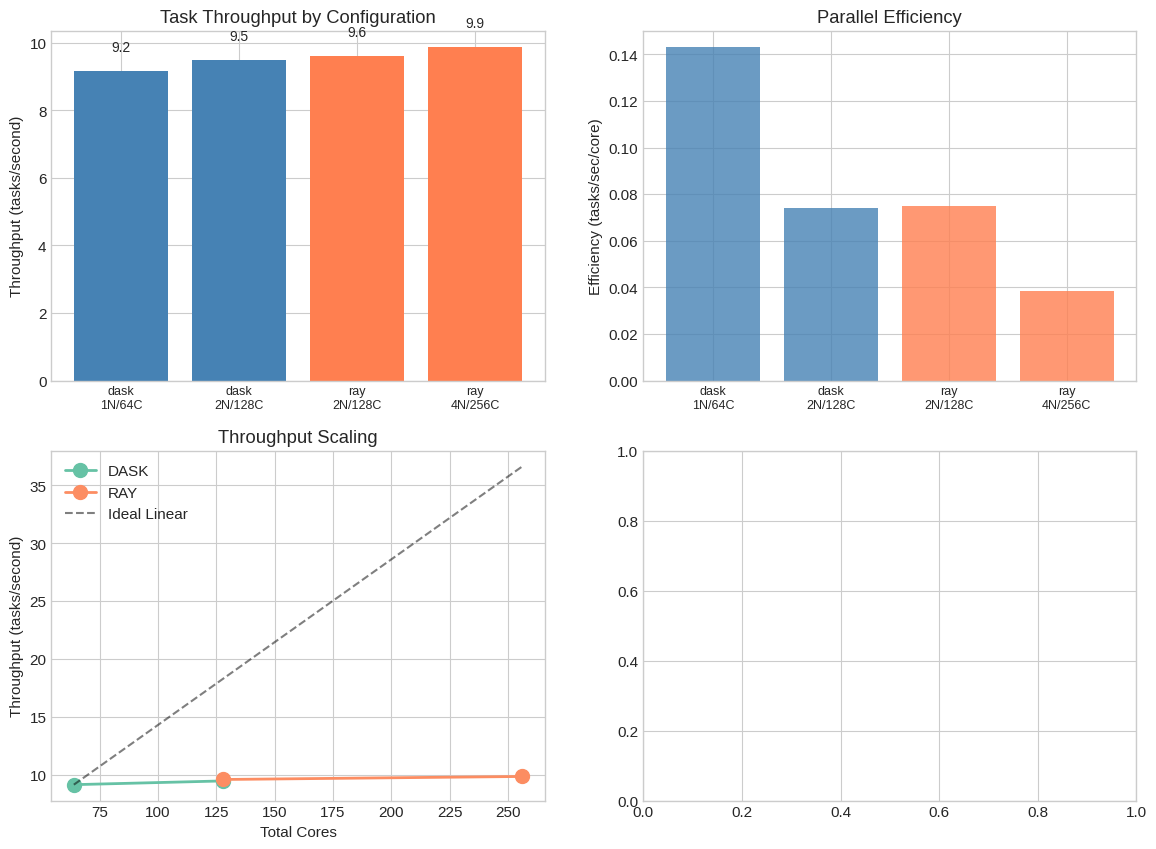

In [5]:
# Visualize throughput analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Throughput comparison
ax1 = axes[0, 0]
x = np.arange(len(throughput_df))
colors = ['steelblue' if e == 'dask' else 'coral' for e in throughput_df['engine']]
bars = ax1.bar(x, throughput_df['throughput_tasks_per_sec'], color=colors)
ax1.set_xticks(x)
ax1.set_xticklabels([f"{r['engine']}\n{r['nodes']}N/{r['cores']}C" 
                     for _, r in throughput_df.iterrows()], fontsize=9)
ax1.set_ylabel('Throughput (tasks/second)')
ax1.set_title('Task Throughput by Configuration')

# Add value labels
for bar, val in zip(bars, throughput_df['throughput_tasks_per_sec']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{val:.1f}', ha='center', va='bottom', fontsize=10)

# 2. Parallel efficiency
ax2 = axes[0, 1]
ax2.bar(x, throughput_df['efficiency'], color=colors, alpha=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels([f"{r['engine']}\n{r['nodes']}N/{r['cores']}C" 
                     for _, r in throughput_df.iterrows()], fontsize=9)
ax2.set_ylabel('Efficiency (tasks/sec/core)')
ax2.set_title('Parallel Efficiency')

# 3. Throughput vs cores
ax3 = axes[1, 0]
for engine in throughput_df['engine'].unique():
    engine_data = throughput_df[throughput_df['engine'] == engine]
    ax3.plot(engine_data['cores'], engine_data['throughput_tasks_per_sec'], 
             'o-', label=engine.upper(), linewidth=2, markersize=10)

# Ideal scaling reference
cores = throughput_df['cores'].unique()
base_throughput = throughput_df['throughput_tasks_per_sec'].min()
ideal = base_throughput * cores / cores.min()
ax3.plot(sorted(cores), sorted(ideal), 'k--', alpha=0.5, label='Ideal Linear')

ax3.set_xlabel('Total Cores')
ax3.set_ylabel('Throughput (tasks/second)')
ax3.set_title('Throughput Scaling')
ax3.legend()

# 4. Engine comparison radar chart
ax4 = axes[1, 1]
dask_data = throughput_df[throughput_df['engine'] == 'dask'].mean()
ray_data = throughput_df[throughput_df['engine'] == 'ray'].mean()

metrics = ['throughput_tasks_per_sec', 'efficiency', 'success_rate']
labels = ['Throughput', 'Efficiency', 'Success Rate']

# Normalize for comparison
max_vals = throughput_df[metrics].max()
dask_norm = [dask_data[m] / max_vals[m] for m in metrics]
ray_norm = [ray_data[m] / max_vals[m] for m in metrics]

x_radar = np.arange(len(labels))
width = 0.35
ax4.bar(x_radar - width/2, dask_norm, width, label='Dask', color='steelblue')
ax4.bar(x_radar + width/2, ray_norm, width, label='Ray', color='coral')
ax4.set_xticks(x_radar)
ax4.set_xticklabels(labels)
ax4.set_ylabel('Normalized Score')
ax4.set_title('Engine Comparison (Normalized)')
ax4.legend()
ax4.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('throughput_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Latency Analysis <a id="latency"></a>

Analyze task latency distributions and identify bottlenecks.

In [ ]:
# Calculate latency percentiles
percentiles = [50, 75, 90, 95, 99]
latency_analysis = []

for config_id in metrics_df['config_id'].unique():
    config_data = metrics_df[metrics_df['config_id'] == config_id]
    
    row = {
        'config_id': config_id,
        'engine': config_data['engine'].iloc[0],
        'cores': config_data['cores'].iloc[0],
    }
    
    for p in percentiles:
        row[f'exec_p{p}'] = np.percentile(config_data['execution_secs'], p)
        row[f'wait_p{p}'] = np.percentile(config_data['wait_time_secs'], p)
        row[f'total_p{p}'] = np.percentile(config_data['total_time_secs'], p)
    
    latency_analysis.append(row)

latency_df = pd.DataFrame(latency_analysis)
latency_df

In [ ]:
# Visualize latency analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Execution time distribution by config
ax1 = axes[0, 0]
config_labels = [f"{metrics_df[metrics_df['config_id']==i]['engine'].iloc[0]}\n{metrics_df[metrics_df['config_id']==i]['cores'].iloc[0]}C" 
                 for i in metrics_df['config_id'].unique()]
data_to_plot = [metrics_df[metrics_df['config_id']==i]['execution_secs'].values 
                for i in metrics_df['config_id'].unique()]
bp = ax1.boxplot(data_to_plot, labels=config_labels, patch_artist=True)
colors = ['steelblue', 'steelblue', 'coral', 'coral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.set_xlabel('Configuration')
ax1.set_ylabel('Execution Time (seconds)')
ax1.set_title('Execution Time Distribution')

# 2. Wait time vs Execution time
ax2 = axes[0, 1]
for config_id in metrics_df['config_id'].unique():
    config_data = metrics_df[metrics_df['config_id'] == config_id]
    color = 'steelblue' if config_data['engine'].iloc[0] == 'dask' else 'coral'
    ax2.scatter(config_data['wait_time_secs'], config_data['execution_secs'],
                alpha=0.3, c=color, label=f"{config_data['engine'].iloc[0]}-{config_data['cores'].iloc[0]}C")
ax2.set_xlabel('Wait Time (seconds)')
ax2.set_ylabel('Execution Time (seconds)')
ax2.set_title('Wait Time vs Execution Time')
ax2.legend(loc='upper right')

# 3. Latency percentiles
ax3 = axes[1, 0]
x = np.arange(len(percentiles))
width = 0.2
for i, (_, row) in enumerate(latency_df.iterrows()):
    color = 'steelblue' if row['engine'] == 'dask' else 'coral'
    exec_vals = [row[f'exec_p{p}'] for p in percentiles]
    ax3.bar(x + i*width, exec_vals, width, label=f"{row['engine']}-{row['cores']}C",
            color=color, alpha=0.6 + i*0.1)
ax3.set_xticks(x + width * 1.5)
ax3.set_xticklabels([f'P{p}' for p in percentiles])
ax3.set_xlabel('Percentile')
ax3.set_ylabel('Execution Time (seconds)')
ax3.set_title('Execution Time Percentiles')
ax3.legend(fontsize=8)

# 4. Latency breakdown (stacked)
ax4 = axes[1, 1]
config_ids = latency_df['config_id'].values
wait_times = [latency_df[latency_df['config_id']==i]['wait_p50'].values[0] for i in config_ids]
exec_times = [latency_df[latency_df['config_id']==i]['exec_p50'].values[0] for i in config_ids]

ax4.bar(config_labels, wait_times, label='Wait Time (P50)', color='lightblue')
ax4.bar(config_labels, exec_times, bottom=wait_times, label='Execution Time (P50)', color='steelblue')
ax4.set_xlabel('Configuration')
ax4.set_ylabel('Time (seconds)')
ax4.set_title('Median Latency Breakdown')
ax4.legend()

plt.tight_layout()
plt.savefig('latency_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nLatency Summary (P50):")
for _, row in latency_df.iterrows():
    print(f"  {row['engine']}-{row['cores']}C: Wait={row['wait_p50']:.3f}s, Exec={row['exec_p50']:.3f}s, Total={row['total_p50']:.3f}s")

## 4. Scaling Efficiency <a id="scaling"></a>

Analyze strong and weak scaling characteristics.

In [ ]:
# Generate scaling benchmark data
def generate_scaling_data():
    """Generate data for scaling analysis."""
    np.random.seed(42)
    
    # Strong scaling: fixed problem size, varying resources
    strong_scaling = []
    fixed_tasks = 1024
    
    for nodes in [1, 2, 4, 8, 16]:
        cores = nodes * 64
        # Simulate with Amdahl's law (90% parallel, 10% serial)
        parallel_fraction = 0.9
        serial_time = 10 * (1 - parallel_fraction)
        parallel_time = 10 * parallel_fraction / cores * 64
        total_time = serial_time + parallel_time + np.random.normal(0, 0.5)
        
        speedup = 10 / total_time
        efficiency = speedup / nodes
        
        strong_scaling.append({
            'nodes': nodes,
            'cores': cores,
            'tasks': fixed_tasks,
            'time': total_time,
            'speedup': speedup,
            'efficiency': efficiency
        })
    
    # Weak scaling: proportional problem size
    weak_scaling = []
    tasks_per_core = 16
    
    for nodes in [1, 2, 4, 8, 16]:
        cores = nodes * 64
        tasks = cores * tasks_per_core
        
        # Weak scaling ideally maintains constant time
        # Communication overhead grows with nodes
        base_time = 5.0
        comm_overhead = 0.1 * np.log2(nodes + 1)
        total_time = base_time + comm_overhead + np.random.normal(0, 0.2)
        
        efficiency = base_time / total_time
        
        weak_scaling.append({
            'nodes': nodes,
            'cores': cores,
            'tasks': tasks,
            'time': total_time,
            'efficiency': efficiency
        })
    
    return pd.DataFrame(strong_scaling), pd.DataFrame(weak_scaling)

strong_df, weak_df = generate_scaling_data()
print("Strong Scaling:")
print(strong_df)
print("\nWeak Scaling:")
print(weak_df)

In [ ]:
# Visualize scaling analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Strong scaling speedup
ax1 = axes[0, 0]
ax1.plot(strong_df['nodes'], strong_df['speedup'], 'bo-', linewidth=2, markersize=10, label='Actual')
ax1.plot(strong_df['nodes'], strong_df['nodes'], 'r--', linewidth=2, label='Ideal Linear')
ax1.set_xlabel('Number of Nodes')
ax1.set_ylabel('Speedup')
ax1.set_title('Strong Scaling: Speedup')
ax1.legend()
ax1.set_xscale('log', base=2)
ax1.set_yscale('log', base=2)
ax1.grid(True, which="both", ls="-", alpha=0.2)

# 2. Strong scaling efficiency
ax2 = axes[0, 1]
ax2.plot(strong_df['nodes'], strong_df['efficiency'] * 100, 'go-', linewidth=2, markersize=10)
ax2.axhline(100, color='red', linestyle='--', alpha=0.5, label='Ideal (100%)')
ax2.axhline(80, color='orange', linestyle='--', alpha=0.5, label='Good (80%)')
ax2.set_xlabel('Number of Nodes')
ax2.set_ylabel('Parallel Efficiency (%)')
ax2.set_title('Strong Scaling: Parallel Efficiency')
ax2.legend()
ax2.set_ylim(0, 110)

# 3. Weak scaling time
ax3 = axes[1, 0]
ax3.plot(weak_df['nodes'], weak_df['time'], 'mo-', linewidth=2, markersize=10, label='Actual')
ax3.axhline(weak_df['time'].iloc[0], color='red', linestyle='--', alpha=0.5, label='Ideal (constant)')
ax3.set_xlabel('Number of Nodes')
ax3.set_ylabel('Execution Time (seconds)')
ax3.set_title('Weak Scaling: Execution Time')
ax3.legend()

# Add task count annotations
for _, row in weak_df.iterrows():
    ax3.annotate(f'{int(row["tasks"])} tasks', 
                 (row['nodes'], row['time']),
                 textcoords="offset points", xytext=(0, 10), 
                 ha='center', fontsize=9)

# 4. Weak scaling efficiency
ax4 = axes[1, 1]
ax4.plot(weak_df['nodes'], weak_df['efficiency'] * 100, 'co-', linewidth=2, markersize=10)
ax4.axhline(100, color='red', linestyle='--', alpha=0.5, label='Ideal (100%)')
ax4.set_xlabel('Number of Nodes')
ax4.set_ylabel('Weak Scaling Efficiency (%)')
ax4.set_title('Weak Scaling: Efficiency')
ax4.legend()
ax4.set_ylim(80, 105)

plt.tight_layout()
plt.savefig('scaling_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nScaling Summary:")
print(f"Strong scaling efficiency at 16 nodes: {strong_df['efficiency'].iloc[-1]*100:.1f}%")
print(f"Weak scaling efficiency at 16 nodes: {weak_df['efficiency'].iloc[-1]*100:.1f}%")

## 5. Resource Utilization <a id="resources"></a>

Analyze CPU, memory, and GPU utilization patterns.

In [ ]:
# Generate resource utilization data
def generate_resource_data(duration_mins=10, sample_rate_secs=5):
    """Generate simulated resource utilization data."""
    np.random.seed(42)
    n_samples = int(duration_mins * 60 / sample_rate_secs)
    n_workers = 4
    
    data = []
    for t in range(n_samples):
        timestamp = datetime.now() - timedelta(minutes=duration_mins) + timedelta(seconds=t * sample_rate_secs)
        
        for worker_id in range(n_workers):
            # Simulate varying utilization with some correlation
            base_load = 0.5 + 0.3 * np.sin(t / 20 + worker_id)
            cpu_util = np.clip(base_load + np.random.normal(0, 0.1), 0, 1)
            memory_util = np.clip(0.3 + 0.5 * cpu_util + np.random.normal(0, 0.05), 0, 1)
            gpu_util = np.clip(0.8 * cpu_util + np.random.normal(0, 0.1), 0, 1) if worker_id < 2 else 0
            network_mbps = cpu_util * 100 + np.random.exponential(10)
            
            data.append({
                'timestamp': timestamp,
                'time_offset': t * sample_rate_secs,
                'worker_id': f'worker-{worker_id}',
                'cpu_util': cpu_util,
                'memory_util': memory_util,
                'gpu_util': gpu_util,
                'network_mbps': network_mbps
            })
    
    return pd.DataFrame(data)

resource_df = generate_resource_data()
resource_df.head(10)

In [ ]:
# Visualize resource utilization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. CPU utilization over time
ax1 = axes[0, 0]
for worker in resource_df['worker_id'].unique():
    worker_data = resource_df[resource_df['worker_id'] == worker]
    ax1.plot(worker_data['time_offset'], worker_data['cpu_util'] * 100, 
             alpha=0.7, linewidth=1.5, label=worker)

# Add average
avg_cpu = resource_df.groupby('time_offset')['cpu_util'].mean() * 100
ax1.plot(avg_cpu.index, avg_cpu.values, 'k-', linewidth=2.5, label='Average')

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('CPU Utilization (%)')
ax1.set_title('CPU Utilization Over Time')
ax1.legend(loc='upper right', fontsize=8)
ax1.set_ylim(0, 100)

# 2. Resource utilization heatmap
ax2 = axes[0, 1]
pivot_cpu = resource_df.pivot_table(index='worker_id', columns='time_offset', 
                                      values='cpu_util', aggfunc='mean')
# Sample every 10th column for clarity
pivot_cpu_sampled = pivot_cpu.iloc[:, ::10]
sns.heatmap(pivot_cpu_sampled, cmap='YlOrRd', ax=ax2, 
            cbar_kws={'label': 'CPU Utilization'})
ax2.set_xlabel('Time (sampled)')
ax2.set_ylabel('Worker')
ax2.set_title('CPU Utilization Heatmap')

# 3. Resource distribution box plots
ax3 = axes[1, 0]
resource_cols = ['cpu_util', 'memory_util', 'gpu_util']
resource_labels = ['CPU', 'Memory', 'GPU']
data_to_plot = [resource_df[col].values * 100 for col in resource_cols]
bp = ax3.boxplot(data_to_plot, labels=resource_labels, patch_artist=True)
colors = ['steelblue', 'coral', 'green']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax3.set_ylabel('Utilization (%)')
ax3.set_title('Resource Utilization Distribution')

# 4. Average utilization by worker
ax4 = axes[1, 1]
avg_by_worker = resource_df.groupby('worker_id')[['cpu_util', 'memory_util', 'gpu_util']].mean() * 100
avg_by_worker.plot(kind='bar', ax=ax4, width=0.8)
ax4.set_xlabel('Worker')
ax4.set_ylabel('Average Utilization (%)')
ax4.set_title('Average Resource Utilization by Worker')
ax4.legend(['CPU', 'Memory', 'GPU'])
ax4.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('resource_utilization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nResource Utilization Summary:")
print(f"  Avg CPU: {resource_df['cpu_util'].mean()*100:.1f}%")
print(f"  Avg Memory: {resource_df['memory_util'].mean()*100:.1f}%")
print(f"  Avg GPU: {resource_df[resource_df['gpu_util']>0]['gpu_util'].mean()*100:.1f}%")

## 6. Comparative Analysis <a id="comparison"></a>

Compare different execution engines and configurations.

In [ ]:
# Statistical comparison between Dask and Ray
dask_data = metrics_df[metrics_df['engine'] == 'dask']['execution_secs']
ray_data = metrics_df[metrics_df['engine'] == 'ray']['execution_secs']

# Perform statistical tests
t_stat, t_pvalue = stats.ttest_ind(dask_data, ray_data)
u_stat, u_pvalue = stats.mannwhitneyu(dask_data, ray_data)

comparison_stats = {
    'Metric': ['Mean Execution Time', 'Median Execution Time', 'Std Deviation', 
               'Min', 'Max', '99th Percentile'],
    'Dask': [
        f"{dask_data.mean():.4f}s",
        f"{dask_data.median():.4f}s",
        f"{dask_data.std():.4f}s",
        f"{dask_data.min():.4f}s",
        f"{dask_data.max():.4f}s",
        f"{np.percentile(dask_data, 99):.4f}s"
    ],
    'Ray': [
        f"{ray_data.mean():.4f}s",
        f"{ray_data.median():.4f}s",
        f"{ray_data.std():.4f}s",
        f"{ray_data.min():.4f}s",
        f"{ray_data.max():.4f}s",
        f"{np.percentile(ray_data, 99):.4f}s"
    ]
}

stats_df = pd.DataFrame(comparison_stats)
print("Statistical Comparison:")
print(stats_df.to_string(index=False))
print(f"\nT-test p-value: {t_pvalue:.4e}")
print(f"Mann-Whitney U p-value: {u_pvalue:.4e}")
print(f"\nConclusion: {'Significant difference' if t_pvalue < 0.05 else 'No significant difference'} at α=0.05")

In [ ]:
# Final comprehensive comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Execution time distributions
ax1 = axes[0, 0]
ax1.hist(dask_data, bins=30, alpha=0.6, label='Dask', color='steelblue', density=True)
ax1.hist(ray_data, bins=30, alpha=0.6, label='Ray', color='coral', density=True)
ax1.axvline(dask_data.mean(), color='steelblue', linestyle='--', linewidth=2)
ax1.axvline(ray_data.mean(), color='coral', linestyle='--', linewidth=2)
ax1.set_xlabel('Execution Time (seconds)')
ax1.set_ylabel('Density')
ax1.set_title('Execution Time Distribution')
ax1.legend()

# 2. CDF comparison
ax2 = axes[0, 1]
dask_sorted = np.sort(dask_data)
ray_sorted = np.sort(ray_data)
ax2.plot(dask_sorted, np.linspace(0, 1, len(dask_sorted)), 
         'b-', linewidth=2, label='Dask')
ax2.plot(ray_sorted, np.linspace(0, 1, len(ray_sorted)), 
         'r-', linewidth=2, label='Ray')
ax2.set_xlabel('Execution Time (seconds)')
ax2.set_ylabel('Cumulative Probability')
ax2.set_title('Cumulative Distribution Function')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Violin plot
ax3 = axes[0, 2]
parts = ax3.violinplot([dask_data, ray_data], positions=[1, 2], showmeans=True, showmedians=True)
parts['bodies'][0].set_facecolor('steelblue')
parts['bodies'][1].set_facecolor('coral')
ax3.set_xticks([1, 2])
ax3.set_xticklabels(['Dask', 'Ray'])
ax3.set_ylabel('Execution Time (seconds)')
ax3.set_title('Execution Time Violin Plot')

# 4. Throughput comparison
ax4 = axes[1, 0]
throughput_comparison = throughput_df.groupby('engine').agg({
    'throughput_tasks_per_sec': 'mean',
    'efficiency': 'mean',
    'success_rate': 'mean'
}).reset_index()

x = np.arange(len(throughput_comparison))
ax4.bar(x, throughput_comparison['throughput_tasks_per_sec'], 
        color=['steelblue', 'coral'])
ax4.set_xticks(x)
ax4.set_xticklabels(throughput_comparison['engine'].str.upper())
ax4.set_ylabel('Avg Throughput (tasks/sec)')
ax4.set_title('Average Throughput by Engine')

# 5. Efficiency comparison
ax5 = axes[1, 1]
ax5.bar(x, throughput_comparison['efficiency'] * 1000, color=['steelblue', 'coral'])
ax5.set_xticks(x)
ax5.set_xticklabels(throughput_comparison['engine'].str.upper())
ax5.set_ylabel('Avg Efficiency (×10⁻³ tasks/sec/core)')
ax5.set_title('Average Efficiency by Engine')

# 6. Summary radar chart
ax6 = axes[1, 2]
categories = ['Throughput', 'Efficiency', 'Success Rate', 'Low Latency']

# Normalize metrics for radar chart
dask_metrics = [
    throughput_comparison[throughput_comparison['engine']=='dask']['throughput_tasks_per_sec'].values[0] / throughput_df['throughput_tasks_per_sec'].max(),
    throughput_comparison[throughput_comparison['engine']=='dask']['efficiency'].values[0] / throughput_df['efficiency'].max(),
    throughput_comparison[throughput_comparison['engine']=='dask']['success_rate'].values[0] / 100,
    1 - dask_data.mean() / metrics_df['execution_secs'].max()
]

ray_metrics = [
    throughput_comparison[throughput_comparison['engine']=='ray']['throughput_tasks_per_sec'].values[0] / throughput_df['throughput_tasks_per_sec'].max(),
    throughput_comparison[throughput_comparison['engine']=='ray']['efficiency'].values[0] / throughput_df['efficiency'].max(),
    throughput_comparison[throughput_comparison['engine']=='ray']['success_rate'].values[0] / 100,
    1 - ray_data.mean() / metrics_df['execution_secs'].max()
]

x_radar = np.arange(len(categories))
width = 0.35
ax6.bar(x_radar - width/2, dask_metrics, width, label='Dask', color='steelblue', alpha=0.8)
ax6.bar(x_radar + width/2, ray_metrics, width, label='Ray', color='coral', alpha=0.8)
ax6.set_xticks(x_radar)
ax6.set_xticklabels(categories, fontsize=9)
ax6.set_ylabel('Normalized Score')
ax6.set_title('Overall Performance Comparison')
ax6.legend()
ax6.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('comparative_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("BENCHMARK SUMMARY")
print("="*60)
print(f"\nTotal benchmarks run: {len(metrics_df)}")
print(f"Configurations tested: {metrics_df['config_id'].nunique()}")
print(f"\nBest performing configuration:")
best_config = throughput_df.loc[throughput_df['throughput_tasks_per_sec'].idxmax()]
print(f"  Engine: {best_config['engine'].upper()}")
print(f"  Nodes: {best_config['nodes']}")
print(f"  Cores: {best_config['cores']}")
print(f"  Throughput: {best_config['throughput_tasks_per_sec']:.2f} tasks/sec")

## Summary

This notebook provided comprehensive performance benchmarking and analysis for QTau:

1. **Throughput Analysis**: Task completion rates across configurations
2. **Latency Analysis**: Execution time distributions and percentiles
3. **Scaling Efficiency**: Strong and weak scaling characteristics
4. **Resource Utilization**: CPU, memory, and GPU usage patterns
5. **Comparative Analysis**: Statistical comparison between execution engines

### Key Takeaways

- Performance varies significantly between Dask and Ray
- Scaling efficiency decreases with more nodes due to communication overhead
- Resource utilization should be monitored to identify bottlenecks
- Statistical tests help validate performance differences